In [1]:
import os
import numpy as np 
import pandas as pd 

import skimage.io 
import cv2 
from tqdm.notebook import tqdm 

import matplotlib.pyplot as plt
import matplotlib.colors

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

PATH = "../input/prostate-cancer-grade-assessment/"

df_train = pd.read_csv(f'{PATH}train.csv')
df_test = pd.read_csv(f'{PATH}test.csv')

df_train.head().style.set_caption('Quick Overview of train.csv')

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


In [2]:
print(f"Number of training data: {len(df_train)}\n")

print(f"Unique data_providers: {df_train.data_provider.unique()}\n")
print(f"Unique isup_grade: {df_train.isup_grade.unique()}\n")
print(f"Unique gleason_score: {df_train.gleason_score.unique()}\n")

print(f"Missing data:\n{df_train.isna().any()}\n")

masks = os.listdir(PATH + 'train_label_masks/')
images = os.listdir(PATH + 'train_images/')

df_masks = pd.Series(masks).to_frame()
df_masks.columns = ['mask_file_name']
df_masks['image_id'] = df_masks.mask_file_name.apply(lambda x: x.split('_')[0])
df_train = pd.merge(df_train, df_masks, on='image_id', how='outer')
del df_masks
print(f"There are {len(df_train[df_train.mask_file_name.isna()])} images without a mask.")

Number of training data: 10616

Unique data_providers: ['karolinska' 'radboud']

Unique isup_grade: [0 4 1 3 5 2]

Unique gleason_score: ['0+0' '4+4' '3+3' '4+3' 'negative' '4+5' '3+4' '5+4' '5+5' '5+3' '3+5']

Missing data:
image_id         False
data_provider    False
isup_grade       False
gleason_score    False
dtype: bool

There are 100 images without a mask.


In [3]:
print(f"Train data shape before reduction: {len(df_train)}")
df_train_red = df_train[~df_train.mask_file_name.isna()]
print(f"Train data shape after reduction: {len(df_train_red)}")

no_masks = df_train[df_train.mask_file_name.isna()][['image_id']]
no_masks['Suspicious_because'] = 'No Mask'

Train data shape before reduction: 10616
Train data shape after reduction: 10516


In [4]:
df_train_red.groupby('isup_grade').gleason_score.unique().to_frame().style.set_caption('Mapping of ISUP Grade to Gleason Score')

,gleason_score
isup_grade,
0,['0+0' 'negative']
1,['3+3']
2,['3+4' '4+3']
3,['4+3']
4,['4+4' '5+3' '3+5']
5,['4+5' '5+4' '5+5']


In [5]:
df_train_red[(df_train_red.isup_grade == 2) & (df_train_red.gleason_score != '3+4')]

,image_id,data_provider,isup_grade,gleason_score,mask_file_name
7273,b0a92a74cb53899311acc30b7405e101,karolinska,2,4+3,b0a92a74cb53899311acc30b7405e101_mask.tiff


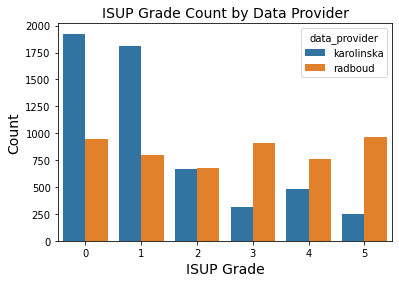

In [6]:
providers = df_train_red.data_provider.unique()

fig = plt.figure(figsize=(6,4))
ax = sns.countplot(x="isup_grade", hue="data_provider", data=df_train_red)
plt.title("ISUP Grade Count by Data Provider", fontsize=14)
plt.xlabel("ISUP Grade", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.show()

In [7]:
df_train_red["height"] = 0
df_train_red["width"] = 0
df_train_red[0] = 0
df_train_red[1] = 0
df_train_red[2] = 0
df_train_red[3] = 0
df_train_red[4] = 0
df_train_red[5] = 0

def get_image_data(row):
    biopsy = skimage.io.MultiImage(PATH + 'train_label_masks/' + row.image_id + '_mask.tiff')
    temp = biopsy[-1][:, :, 0]
    counts = pd.Series(temp.reshape(-1)).value_counts()
    row.height = temp.shape[0]
    row.width = temp.shape[1]
    row.update(counts)
    return row

from tqdm.notebook import tqdm  
tqdm.pandas() 


df_train_red = df_train_red.progress_apply(lambda row: get_image_data(row), axis=1)

df_train_red['pixels'] = df_train_red.height * df_train_red.width


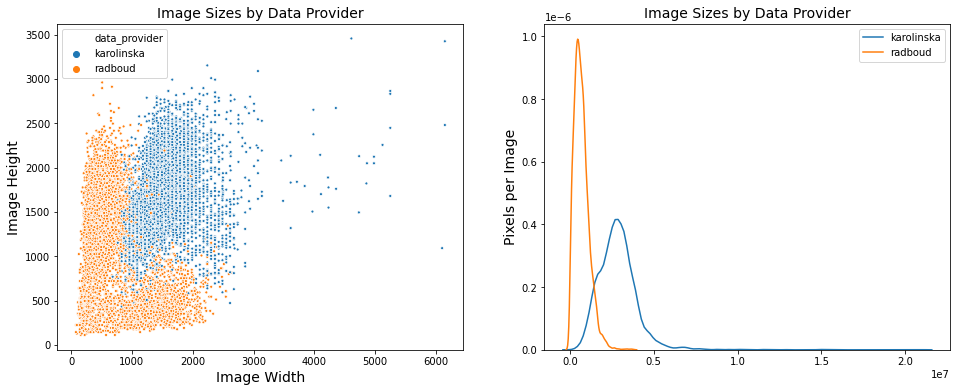

In [8]:
fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

sns.scatterplot(data=df_train_red, x='width', y='height', marker='.',hue='data_provider', ax=ax1)
ax1.set_title("Image Sizes by Data Provider", fontsize=14)
ax1.set_xlabel("Image Width", fontsize=14)
ax1.set_ylabel("Image Height", fontsize=14)

sns.kdeplot(df_train_red[df_train_red.data_provider == 'karolinska'].pixels, label='karolinska', ax=ax2)
sns.kdeplot(df_train_red[df_train_red.data_provider == 'radboud'].pixels, label= 'radboud', ax=ax2)

ax2.set_title("Image Sizes by Data Provider", fontsize=14)
ax2.set_ylabel("Pixels per Image", fontsize=14)
plt.show()

In [9]:
empty_masks = df_train_red[(df_train_red[1] == 0) & (df_train_red[2] ==0)& (df_train_red[3] ==0) & (df_train_red[4] ==0) & (df_train_red[5] ==0)]
print(f"There are {len(empty_masks)} masks that only contain background pixels.")
empty_masks[['image_id', 'data_provider', 'isup_grade', 'gleason_score', 0, 1, 2, 3, 4, 5]]

There are 4 masks that only contain background pixels.


,image_id,data_provider,isup_grade,gleason_score,0,1,2,3,4,5
2227,3790f55cad63053e956fb73027179707,karolinska,0,0+0,3174400.0,0.0,0.0,0.0,0.0,0.0
2961,4a2ca53f240932e46eaf8959cb3f490a,karolinska,1,3+3,3504128.0,0.0,0.0,0.0,0.0,0.0
7003,aaa5732cd49bffddf0d2b7d36fbb0a83,karolinska,1,3+3,3153920.0,0.0,0.0,0.0,0.0,0.0
9415,e4215cfc8c41ec04a55431cc413688a9,karolinska,2,3+4,2236416.0,0.0,0.0,0.0,0.0,0.0


In [10]:
for i in empty_masks.image_id:
    biopsy = skimage.io.MultiImage(PATH + 'train_label_masks/' + i + '_mask.tiff')
    # Check whether all three channels are empty
    no_mask = True
    for j in range(3): 
        if biopsy[-1][:,:, j].max() > 0:
            print(f"Found mask for image {i} in channel {j}")
            no_mask = False
        
    if no_mask == True:
        print(f"Couldn't find mask for image {i} in other channels.")
        
empty_masks = empty_masks[['image_id']]
empty_masks['Suspicious_because'] = 'Background only'

Couldn't find mask for image 3790f55cad63053e956fb73027179707 in other channels.
Couldn't find mask for image 4a2ca53f240932e46eaf8959cb3f490a in other channels.
Couldn't find mask for image aaa5732cd49bffddf0d2b7d36fbb0a83 in other channels.
Couldn't find mask for image e4215cfc8c41ec04a55431cc413688a9 in other channels.


In [11]:
df_train_red[(df_train_red.data_provider == 'karolinska') & (df_train_red.isup_grade > 0) & (df_train_red[2] ==0)][['image_id', 'data_provider', 'isup_grade', 'gleason_score', 0, 1, 2, 3, 4, 5]].style.set_caption('Suspicious Masks provided by Karolinska')

,image_id,data_provider,isup_grade,gleason_score,0,1,2,3,4,5
2961,4a2ca53f240932e46eaf8959cb3f490a,karolinska,1,3+3,3.50413e+06,0,0,0,0,0
7003,aaa5732cd49bffddf0d2b7d36fbb0a83,karolinska,1,3+3,3.15392e+06,0,0,0,0,0
9415,e4215cfc8c41ec04a55431cc413688a9,karolinska,2,3+4,2.23642e+06,0,0,0,0,0


In [12]:
no_cancerous_tissue = df_train_red[(df_train_red.data_provider == 'radboud') & (df_train_red.isup_grade > 0) & (df_train_red[3] ==0) & (df_train_red[4] ==0) & (df_train_red[5] ==0)]
no_cancerous_tissue[['image_id', 'data_provider', 'isup_grade', 'gleason_score', 0, 1, 2, 3, 4, 5]].style.set_caption('Suspicious Masks provided by Radboud')

,image_id,data_provider,isup_grade,gleason_score,0,1,2,3,4,5
12,004dd32d9cd167d9cc31c13b704498af,radboud,1,3+3,598555,117218,5123,0,0,0
34,00d8a8c04886379e266406fdeff81c45,radboud,5,4+5,1.07303e+06,77851,4191,0,0,0
48,014006841b9807edc0ff277c4ab29b91,radboud,4,4+4,55467,45012,897,0,0,0
70,01dfcde514052a6dc35ea4407f41d6e1,radboud,4,4+4,1.01818e+06,108039,13495,0,0,0
197,053a397c936bffc98e62367a81d6c905,radboud,1,3+3,52249,15639,208,0,0,0
573,0e5806abc1cf909123d584e504dd9bf9,radboud,5,5+5,28758,4800,234,0,0,0
575,0e62a4cba998a03d20295e07ebc30958,radboud,4,5+3,25681,11110,73,0,0,0
615,0f914d1f044c187e6a5be7e996d877a9,radboud,1,3+3,273768,39769,63,0,0,0
641,102aaf6f71973e1fe82551918255ba58,radboud,1,3+3,98676,58445,575,0,0,0
642,102c1ec848392aabff3fb4df2aa3598b,radboud,1,3+3,31318,35751,2051,0,0,0


In [13]:
print(f"Train data shape before second reduction: {len(df_train_red)}")
df_train_red = df_train_red[(~df_train_red.image_id.isin(empty_masks.image_id)) & (~df_train_red.image_id.isin(no_cancerous_tissue.image_id))]
print(f"Train data shape after second reduction: {len(df_train_red)}")

no_cancerous_tissue = no_cancerous_tissue[['image_id']]
no_cancerous_tissue['Suspicious_because'] = 'No cancerous tissue but ISUP Grade > 0'

Train data shape before second reduction: 10516
Train data shape after second reduction: 10427


Let's have a quick first look at the differences between the data providers in regards to the original images and the masks.

> **Radboud**: Prostate glands are individually labelled. Valid values are:
* 0: background (non tissue) or unknown
* 1: <span style='background :gray' >stroma (connective tissue, non-epithelium tissue)</span> 
* 2: <span style='background :green' >healthy (benign) epithelium</span> 
* 3: <span style='background :orange' >cancerous epithelium (Gleason 3)</span> 
* 4: <span style='background :red' >cancerous epithelium (Gleason 4)</span> 
* 5: <span style='background :darkred' >cancerous epithelium (Gleason 5)</span> 

>**Karolinska**: Regions are labelled. Valid values are:
* [0]: background (non tissue) or unknown
* [1]: <span style='background :green' >benign tissue (stroma and epithelium combined)</span> 
* [2]: <span style='background :red' >cancerous tissue (stroma and epithelium combined)</span> 

(For Karolinska the description actually says values 1 through 3 but in the masks it is 0 through 2.)

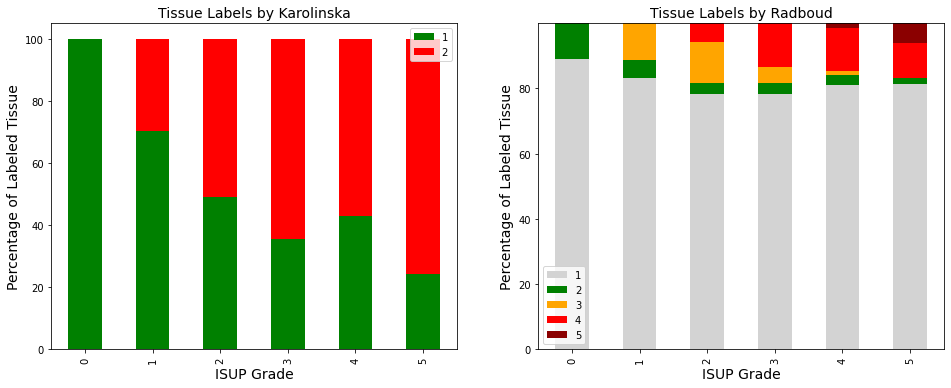

In [14]:
df_train_red['tissue'] = df_train_red[1] + df_train_red[2] + df_train_red[3] + df_train_red[4] + df_train_red[5]

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))


karolinska = df_train_red[df_train_red.data_provider == 'karolinska'].groupby('isup_grade')[[1, 2, 'tissue']].mean()
karolinska[1] = karolinska[1] /karolinska['tissue']*100
karolinska[2] = karolinska[2] /karolinska['tissue'] *100
karolinska = karolinska.drop(['tissue'], axis=1)

karolinska.plot(kind='bar', stacked=True, ax=ax1, cmap = matplotlib.colors.ListedColormap(['green','red']))
ax1.set_title("Tissue Labels by Karolinska", fontsize=14)
ax1.set_xlabel("ISUP Grade", fontsize=14)
ax1.set_ylabel("Percentage of Labeled Tissue", fontsize=14)


radboud = df_train_red[df_train_red.data_provider == 'radboud'].groupby('isup_grade')[[1, 2, 3, 4, 5, 'tissue']].mean()
radboud[1] = radboud[1] /radboud['tissue']*100
radboud[2] = radboud[2] /radboud['tissue'] *100
radboud[3] = radboud[3] /radboud['tissue'] *100
radboud[4] = radboud[4] /radboud['tissue'] *100
radboud[5] = radboud[5] /radboud['tissue'] *100

radboud = radboud.drop(['tissue'], axis=1)

radboud.plot(kind='bar', stacked=True, ax=ax2, cmap = matplotlib.colors.ListedColormap(['lightgrey', 'green', 'orange', 'red', 'darkred']))
ax2.set_title("Tissue Labels by Radboud", fontsize=14)
ax2.set_xlabel("ISUP Grade", fontsize=14)
ax2.set_ylabel("Percentage of Labeled Tissue", fontsize=14)

plt.show()

# Code References

https://www.kaggle.com/code/iamleonie/panda-eda-visualizations-suspicious-data

https://www.kaggle.com/xhlulu/panda-resize-and-save-train-data

https://www.kaggle.com/dhananjay3/panda-eda-all-you-need-to-know